In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import statsmodels
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

from fourinarowfunctions import *

# directory where your data is stored
direc = '../data/'

In [2]:
def should_be_equal(name, actual, expected, warnings):
    if expected != actual:
        warnings.append(f"{name} was expected to be {expected} but was {actual}")

def check_event_counts(data,num_games):
    event_count_dict = defaultdict(lambda: 0, dict(zip(*np.unique([e['event_type'] for e in data],return_counts=True))))
    warnings = []
    should_be_equal("Number of game starts", event_count_dict['start game'], num_games, warnings)
    should_be_equal("Number of game endings", event_count_dict['end game'], num_games, warnings)
    should_be_equal("User moves", event_count_dict['user move'], event_count_dict['your turn'], warnings)
    should_be_equal("Opponent moves", event_count_dict['opponent move'], event_count_dict['waiting for opponent'], warnings)
    should_be_equal("Game outcomes", event_count_dict['opponent win'] + event_count_dict['user win'] + event_count_dict['draw'], event_count_dict['start game'], warnings)
    return warnings

In [3]:
#name of your data file
filename = direc + 'trialdata.csv'
data_dict = load_data(filename)
parsed_dict = {}
for username, data in data_dict.items():
    try:
        parsed_dict[username] = get_parsed_data(data, username)
    except AssertionError as e:
        print(f"Incomplete {username}: {e}")
        continue
usernames = parsed_dict.keys()
print(f"{len(usernames)} users with complete data")

drop test_im:R_2YspUds9g1Pyp6J
drop test_im:R_1LYfkmETpZRD3kn
drop debug:R_3G7Yq6aginiNva2
drop test_im2:R_2YspUds9g1Pyp6J
drop im_full_test:assign_full_test
drop test_im3:R_2YspUds9g1Pyp6J
drop null:R_emsNDLsvWMLPb7X
drop test_im_ff:test_FF_win
drop test_im_edge:test_edge_win
drop twindemo:noas
drop null:R_2qCyb2CeLwcRxH2
drop null:R_25HjvhOMhc79iaa
drop debugYZNI1G:debugDVJFSO
drop test_BO_11:R_1eXnot6X58rnPMv
drop null:R_2zhw77FMGEb36zK
drop debugOCOGDF:debug2TDLTY
drop test_im_ff2:test_FF2_win
drop null:R_2aV9fwk4CR3GjBg
drop debugQWOQ1C:debugOQ8IEY
drop CPTest:R_1QxPuBVlzMbldXa
drop CPTest:R_1FsoM2AkWpLn1Qw
drop im_full_test:ssign_full_test
drop just_a_test_:test
drop debugfull:noas
drop null:R_vou3qrtMy6aHysp
drop debugscreenshot:noas
Loaded 192 participants
Incomplete A108:R_2TnOx7dVPSonpTg: user only finished 27 games
Incomplete A123:R_2viEesh2c9XCBMe: user only finished 27 games
Incomplete A120:R_PONVLZnwDK7wSpr: user only finished 27 games
Incomplete 115:R_241tt6O6tVQs9NR: us

In [4]:
#load other datafiles
age = pd.read_csv(direc + "SubjectAge.csv")
bins = [7, 12, 18, 26]
age['ageBins'] = pd.cut(age['FlooredAge'], bins)

pars = pd.read_csv(direc + "params_with_metrics.csv", index_col=None)
pars['StudyID'] = pars['subject'].str.split(':').str[0]
pars = pd.merge(age, pars, on='StudyID', how='outer')
# pars = pars[pars['iteration'].notna()]

df_rt = pd.read_csv(direc + "reactiontimes.csv")
df_rt['StudyID'] = df_rt['User'].str.split(':').str[0]
df_rt = pd.merge(age, df_rt, on='StudyID', how='outer')
# df_rt.to_csv(direc + 'df_rt.csv', index = False) 

In [5]:
# create reaction times csv
with open(direc + "reactiontimes.csv", "w") as outfile:
    outfile.write("User,GameNr,Category,Level,MoveNr,RT,UserMoves,OpponentMoves,Result\n")
    for username in usernames:
        # First go through all the events and record gane results
        game_data = {}
        for event in data_dict[username]:
            if event["event_type"] == "start game":
                user_moves = 0
                opponent_moves = 0
            elif event["event_type"] == "user move":
                user_moves += 1
            elif event["event_type"] == "opponent move":
                opponent_moves += 1
            elif event["event_type"] == "end game":
                # practice rounds will be overwritten because the "real" rounds have the same game_num
                game_data[event["event_info"]["game_num"]] = {
                    "user_moves": user_moves,
                    "opponent_moves": opponent_moves,
                    "outcome": event["event_info"]["result"]
                }
        is_practice = False
        # Go through all the events a second time and write csv lines as we go
        for event in data_dict[username]:
            if event["event_type"] == "start game":
                ei = event["event_info"]
                game_nr = ei["game_num"]
                move_nr = 0
                is_practice = ei["is_practice"]
                game_info = ",".join([str(x)for x in [game_nr, ei["category"], ei["level"]]])
            elif event["event_type"] == "your turn":
                prompt_time = int(event["event_time"])
            elif event["event_type"] == "user move":
                if is_practice:
                    continue
                move_time = int(event["event_time"])
                move_nr += 1
                gd = game_data[game_nr]
                line = ",".join([username, game_info, str(move_nr), str((move_time - prompt_time) / 1000), str(gd["user_moves"]), str(gd["opponent_moves"]), gd["outcome"]])
                outfile.write(line + "\n")

In [6]:
# Create durations csv
with open(direc + "gameDurations.csv", "w") as outfile:
    outfile.write("User,TotalDurationSeconds,MainDurationSeconds,GamesPlayed\n")
    for username in usernames:
        games_played = 0
        startTime = 0
        endTime = 0
        events = data_dict[username]
        for event in events:
            if event["event_type"] == "start game" and event["event_info"]["game_num"] == 0:
                # Practice and main task both have a game 0, but main task is assigned last
                startTime = event["event_time"]
            elif event["event_type"] == "end game":
                # The endtime keeps being overwritten so we end up with the last one
                endTime = event["event_time"]
                games_played = event["event_info"]["game_num"] + 1 # 0-indexed
        line_elements = [username]
        line_elements.append(str((endTime - events[0]["event_time"]) / 1000) if len(events) >= 1 else "-")
        line_elements.append(str((endTime - startTime) / 1000))
        line_elements.append(str(games_played))
        outfile.write(",".join(line_elements) + "\n")

In [7]:
# the second argument in check_data is the number of games that ought to exist for this user
had_warnings = False
for username, data in parsed_dict.items():
    warnings = check_event_counts(data_dict[username], 37)
    if warnings:
        had_warnings = True
        print(username + " " + "; ".join(warnings))
    for game in data:
        for state in game:
            assert(len(state["bp"].split('1')) - len(state["wp"].split('1')) in [0,1])
print("Some things didn't add up!" if had_warnings else "Everything looks ok")

187:R_3oHOHstFKN4HiLA Number of game endings was expected to be 37 but was 36; Game outcomes was expected to be 37 but was 36
250:R_r2BwOdT2hnmQ5WN Number of game starts was expected to be 37 but was 36; Number of game endings was expected to be 37 but was 36
A242:R_ymscU32j53VKwil Number of game starts was expected to be 37 but was 74; Number of game endings was expected to be 37 but was 74
A1157:R_0GqMhnxN1UuSyZP Number of game endings was expected to be 37 but was 36; Game outcomes was expected to be 37 but was 36
883:R_b255PQj1bstkMjD Number of game endings was expected to be 37 but was 36; Game outcomes was expected to be 37 but was 36
Some things didn't add up!


In [8]:
# This cell is copied from "Calculate metrics and elo.ipynb"
def categoryHist(username, data):
    table = np.empty([0,6])
    category = 2
    for event in data:
        if event['event_type'] == 'user move':
            color = event['event_info']['user_color']
        if event['event_type'] == 'adjust level':
            category = event['event_info']['category']
        if event['event_type'] == 'end game':
            result = event['event_info']['result']
            resultCode = 1 if result == 'win' else -1 if result == 'opponent win' else 0
            table = np.vstack((table, [username, event['event_info']['game_num'], int(category), event['event_info']['level'], color, resultCode]))
    return table

forEloData = np.empty([0,6]) 
for username, userdata in data_dict.items():
    forEloData = np.vstack((forEloData, categoryHist(username, userdata)))
dataFrame = pd.DataFrame(data = forEloData, columns = ['subject', 'gameNumber', 'category', 'level', 'user_color', 'outcome'])
dataFrame["outcome"] = dataFrame["outcome"].astype(int)
dataFrame

,subject,gameNumber,category,level,user_color,outcome
0,166:R_9Nac2hjg6u7BlS1,0,2,1,black,1
1,166:R_9Nac2hjg6u7BlS1,1,2,11,white,1
2,166:R_9Nac2hjg6u7BlS1,0,3,10,black,1
3,166:R_9Nac2hjg6u7BlS1,1,3,27,white,1
4,166:R_9Nac2hjg6u7BlS1,2,4,34,black,1
...,...,...,...,...,...,...
6672,311:R_3pgcvaDmcvM4aTR,30,11,103,black,1
6673,311:R_3pgcvaDmcvM4aTR,31,12,118,white,-1
6674,311:R_3pgcvaDmcvM4aTR,32,11,109,black,1
6675,311:R_3pgcvaDmcvM4aTR,33,11,103,white,1


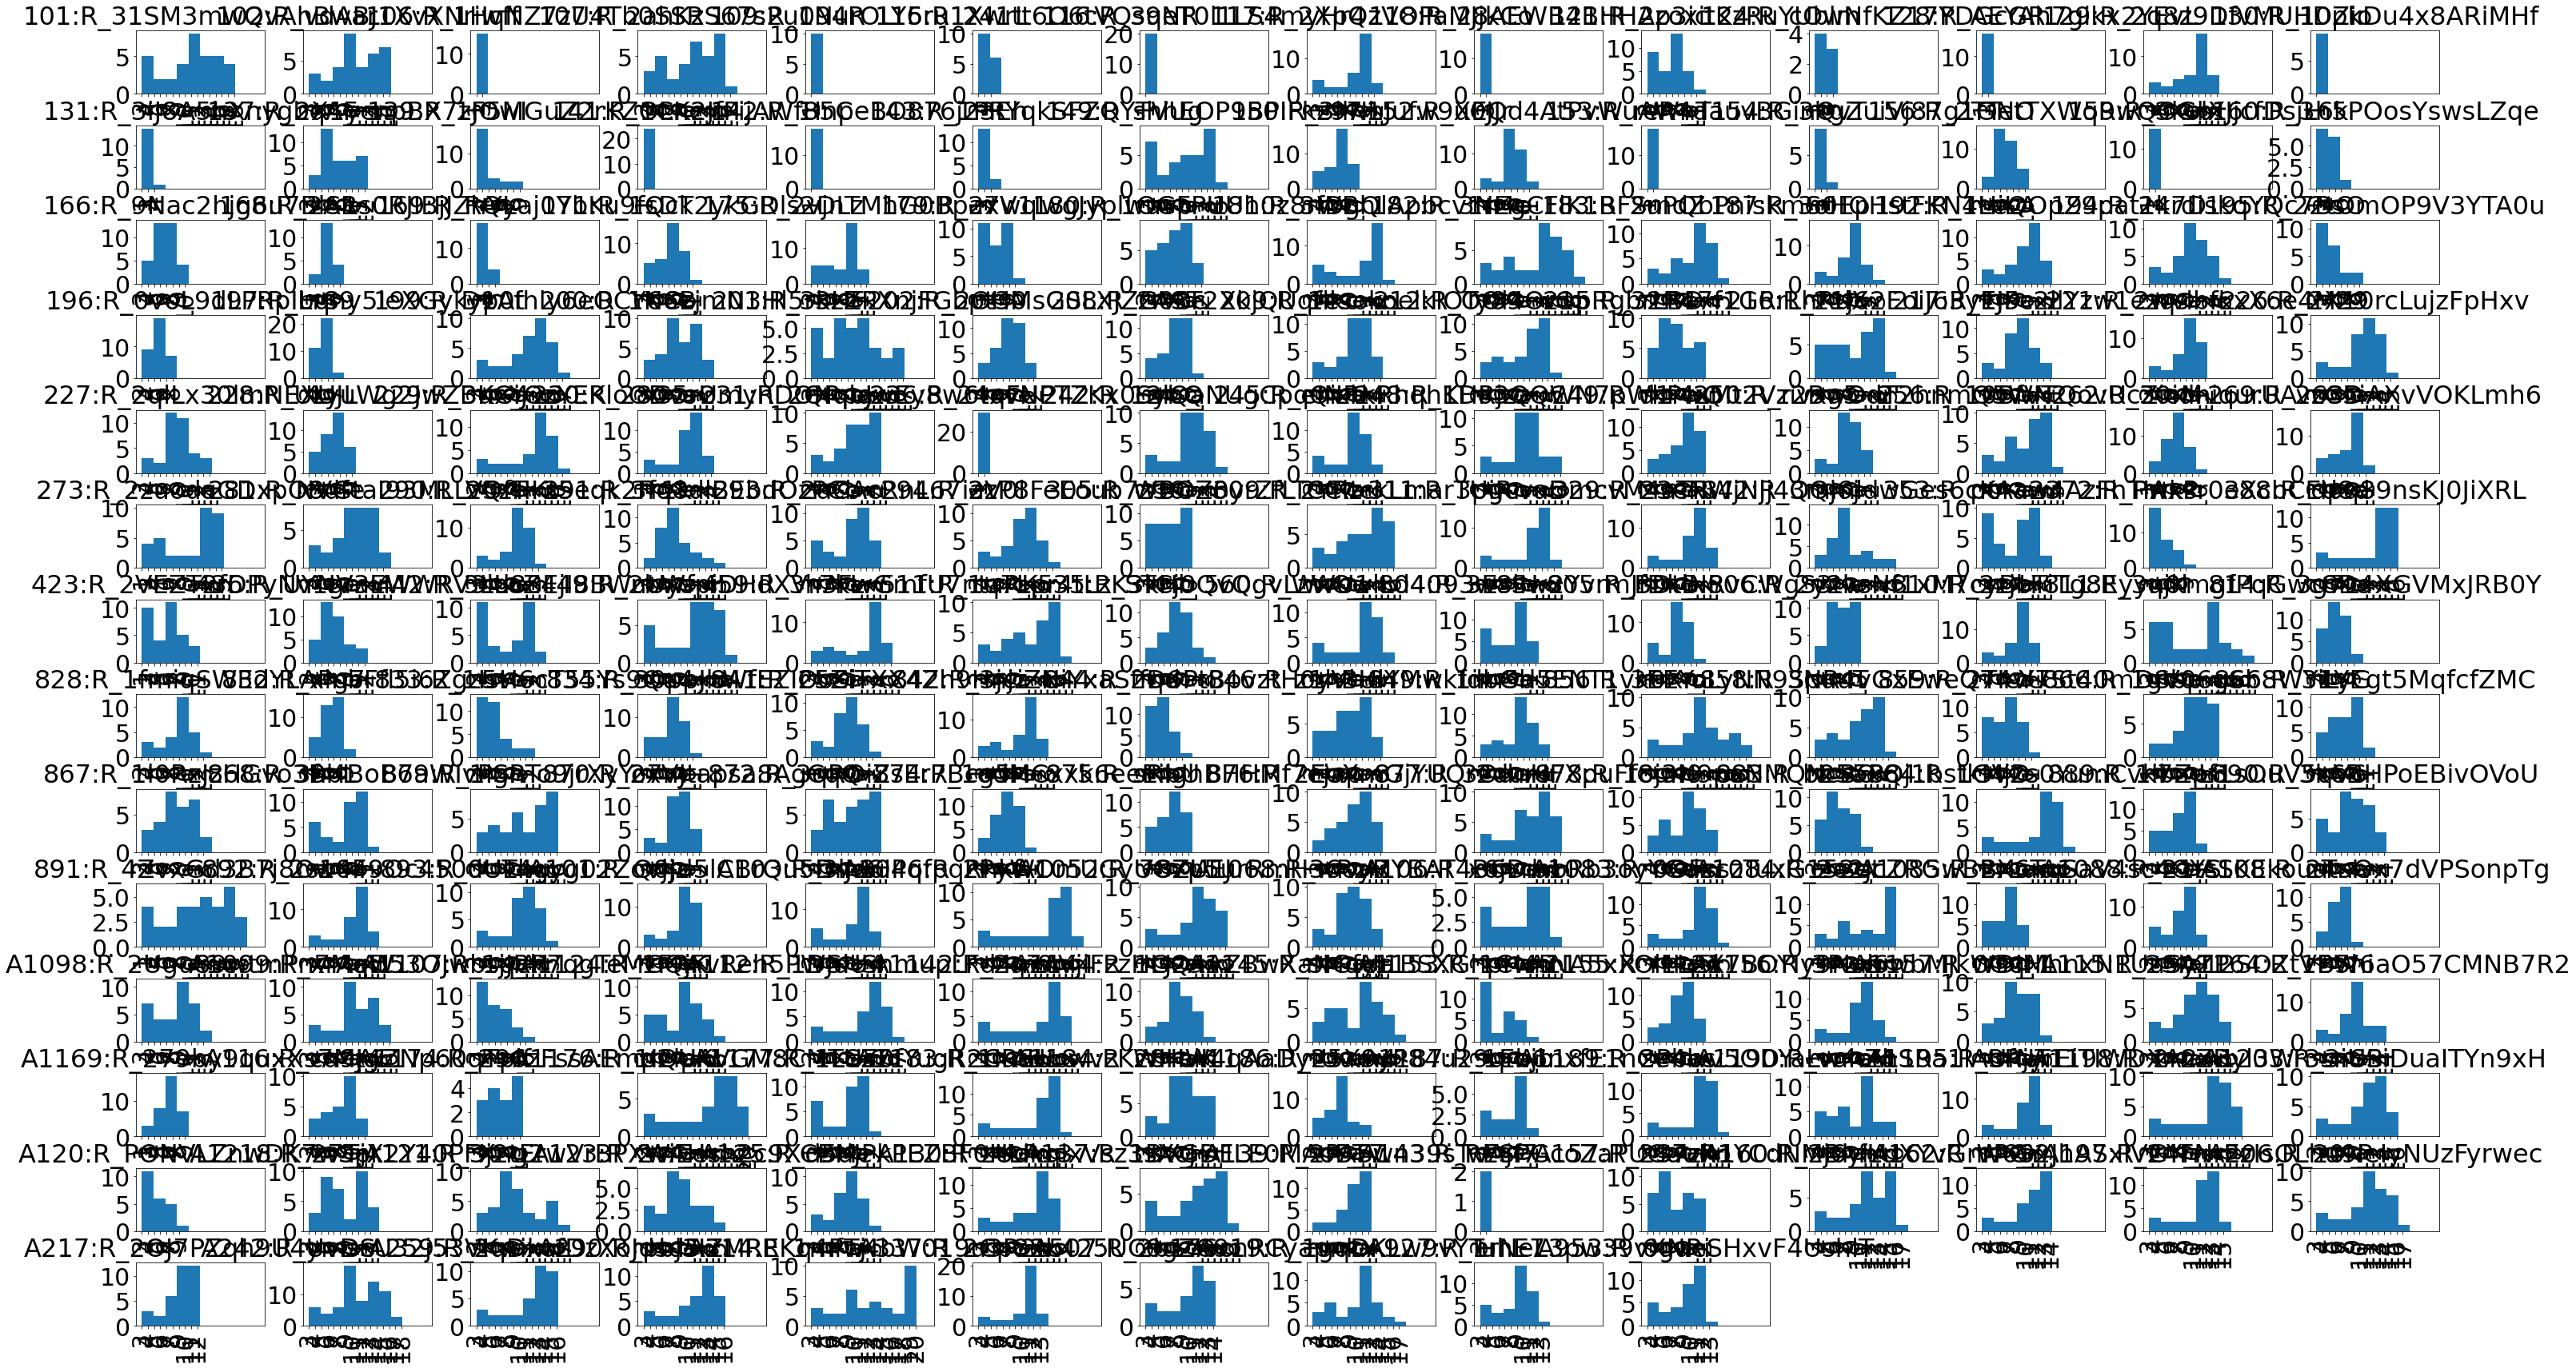

In [9]:
hists = dataFrame['category'].hist(by=dataFrame['subject'], range=[1,20], figsize=(50, 30), xlabelsize=30, ylabelsize=30)
for x in hists.ravel():
    x.title.set_size(32)


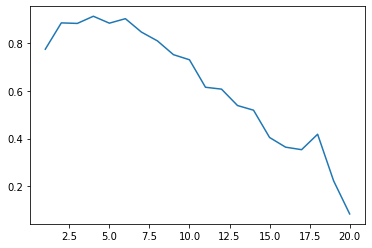

In [10]:
plt.figure()
dataFrame['count'] = 1
dataFrame['win'] = (dataFrame['outcome'] == 1).astype(int)
dataFrame['category'] = pd.to_numeric(dataFrame['category'])
dataWinCount = dataFrame.groupby(['subject', 'category'], as_index=False).sum()
dataWinCount['winRate'] = dataWinCount['win']/dataWinCount['count']
dataWinCount = dataWinCount.groupby(['category'], as_index=False).mean()

plt.plot(dataWinCount['category'],dataWinCount['winRate'] )

Text(0.5, 0, 'Category')

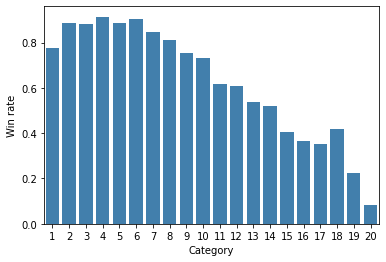

In [11]:
ax = sb.barplot(x="category", y="winRate", data=dataWinCount, ci = None, color = "#3182bd")
plt.ylabel("Win rate")
plt.xlabel("Category")

In [12]:
dataWinCount.head()

,category,outcome,count,win,winRate
0,1,0.604167,6.187500,3.187500,0.775610
1,2,1.984375,2.765625,2.348958,0.886248
2,3,1.882353,2.593583,2.203209,0.884008
3,4,1.305556,1.850000,1.561111,0.914167
4,5,1.295455,2.034091,1.630682,0.885046


In [13]:
dataFrame['subjectNr'] = dataFrame['subject'].str.split(':').str[0]
age['subjectNr'] = age['StudyID']
df_age_cat = pd.merge(age, dataFrame, on='subjectNr', how='outer')
df_age_cat = df_age_cat[df_age_cat['gameNumber'].notna()]
df_age_winrate = df_age_cat.groupby(['subjectNr'], as_index=False).mean()
df_age_medcat = df_age_cat.groupby(['subjectNr'], as_index=False).median()
df_age_maxcat = df_age_cat.groupby(['subjectNr'], as_index=False).max()

# Get all games numbered 0 or 1 (practice and task)
first_games = df_age_cat[pd.to_numeric(df_age_cat['gameNumber']) < 2]
# First games has 4 games per subject: 2 practice 2 task
counter = range(int(len(first_games) / 4))
# Make a list of every 1st and 2nd game (practice games), so excluce every 3rd and 4th (task games)
indices = [x * 4 for x in counter]
indices.extend([x * 4 + 1 for x in counter])
indices.sort()
# Select all the practice games from the df so we can get a list of their indices
practice_games = first_games.iloc[indices]
# Remove the practice indices from df_age_cat. What's left are only task games.
df_age_cat = df_age_cat.drop(practice_games.index)

df_age_cat

,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBins,subjectNr,subject,gameNumber,category,level,user_color,outcome,count,win
2,A101,26-9-1999,F,21.1151,21.0,1-11-2020,"(18.0, 26.0]",A101,A101:R_Q0Jd5lCBrQu5Dm9,0,3,12,black,1,1,1
3,A101,26-9-1999,F,21.1151,21.0,1-11-2020,"(18.0, 26.0]",A101,A101:R_Q0Jd5lCBrQu5Dm9,1,3,22,white,1,1,1
4,A101,26-9-1999,F,21.1151,21.0,1-11-2020,"(18.0, 26.0]",A101,A101:R_Q0Jd5lCBrQu5Dm9,2,4,34,black,1,1,1
5,A101,26-9-1999,F,21.1151,21.0,1-11-2020,"(18.0, 26.0]",A101,A101:R_Q0Jd5lCBrQu5Dm9,3,5,45,white,1,1,1
6,A101,26-9-1999,F,21.1151,21.0,1-11-2020,"(18.0, 26.0]",A101,A101:R_Q0Jd5lCBrQu5Dm9,4,6,55,black,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1187,A1187:R_1Eb6nxfE1nCe4bs,10,10,90,black,1,1,1
6673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1187,A1187:R_1Eb6nxfE1nCe4bs,11,10,98,white,-1,1,0
6674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1187,A1187:R_1Eb6nxfE1nCe4bs,12,9,84,black,1,1,1
6675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1187,A1187:R_1Eb6nxfE1nCe4bs,13,9,82,white,1,1,1


Text(0.5, 0, 'Subject')

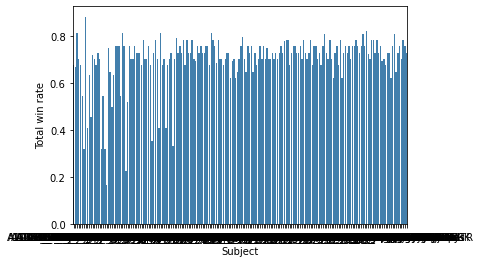

In [14]:
ax = sb.barplot(x="subject", y="win", data=dataFrame, ci = None, color = "#3182bd")
plt.ylabel("Total win rate")
plt.xlabel("Subject")


,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBins,subjectNr,subject,gameNumber,category,level,user_color,outcome,count,win
30,A101,26-9-1999,F,21.1151,21.0,1-11-2020,"(18, 26]",A101,A101:R_Q0Jd5lCBrQu5Dm9,28,11,107,black,1,1,1
60,A103,11-8-2000,F,20.2438,20.0,3-11-2020,"(18, 26]",A103,A103:R_3lJsCIPqfpqRhkf,21,12,115,white,1,1,1
90,A112,24-2-2001,F,19.6904,19.0,29-10-2020,"(18, 26]",A112,A112:R_1DSHShmupLFd4m9,14,12,112,black,1,1,1
120,A121,10-2-2001,F,19.7370,19.0,1-11-2020,"(18, 26]",A121,A121:R_3j2tErwVrBPXWAH,7,9,82,white,-1,1,0
150,A1083,16-10-1997,M,23.0630,23.0,2-11-2020,"(18, 26]",A1083,A1083:R_0OFsszTuxG152et,0,3,14,black,1,1,1
180,A1083,16-10-1997,M,23.0630,23.0,2-11-2020,"(18, 26]",A1083,A1083:R_0OFsszTuxG152et,30,15,146,black,-1,1,0
210,A130,22-10-1998,M,22.0493,22.0,3-11-2020,"(18, 26]",A130,A130:R_zUdkqlxVsz3sXcJ,23,13,121,white,1,1,1
240,101,19-5-2003,F,17.4904,17.0,9-11-2020,"(12, 18]",101,101:R_31SM3mwQvAhBwar,16,12,116,black,0,1,0
270,102,12-11-2005,F,15.0055,15.0,10-11-2020,"(12, 18]",102,102:R_vdABJ1XvXNriwff,9,11,108,white,-1,1,0
300,107,24-2-2008,M,12.7260,12.0,12-11-2020,"(7, 12]",107,107:R_2ahKzS67s2u094R,2,4,34,black,1,1,1


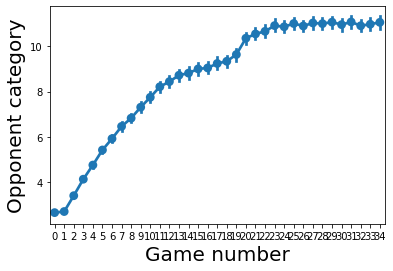

In [15]:
win_age = sb.pointplot(x="gameNumber", y="category", data=df_age_cat, ci =68)
plt.ylabel("Opponent category", fontsize=20)
plt.xlabel("Game number", fontsize=20)
bins = [7, 12, 18, 26]
df_age_cat['ageBins'] = pd.cut(df_age_cat['FlooredAge'], bins)
df_age_cat.loc[df_age_cat.index.intersection([x * 30 for x in range(20)]),:]

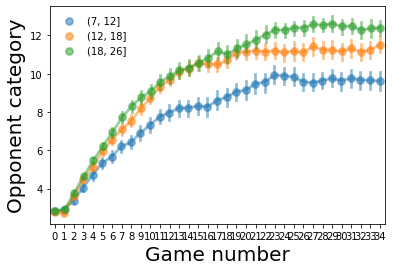

In [16]:
df_age_cat2 = df_age_cat
df_age_cat2["gameNumber"] = pd.to_numeric(df_age_cat2["gameNumber"])
win_age = sb.pointplot(x="gameNumber", y="category", data=df_age_cat2, ci =68, hue = "ageBins", dodge=True,plot_kws=dict(alpha=0.3))
plt.setp(win_age.collections, alpha=.5) #for the markers
plt.setp(win_age.lines, alpha=.5) 
plt.ylabel("Opponent category", fontsize=20)
plt.xlabel("Game number", fontsize=20)
plt.legend(loc='upper left', frameon=False)

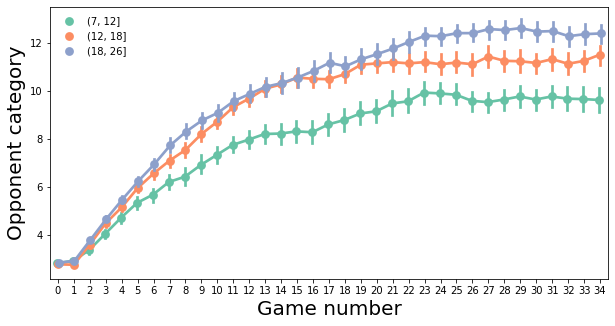

In [17]:
plt.figure(figsize=(10,5))
df_age_cat2 = df_age_cat
df_age_cat2["gameNumber"] = pd.to_numeric(df_age_cat2["gameNumber"])
win_age = sb.pointplot(x="gameNumber", y="category", data=df_age_cat2, ci =68, 
                       hue = "ageBins", dodge=True,plot_kws=dict(alpha=1), palette=sb.color_palette("Set2"),  
                       legend=False)
plt.setp(win_age.collections, alpha=1) #for the markers
plt.setp(win_age.lines, alpha=1) 
plt.ylabel("Opponent category", fontsize=20)
plt.xlabel("Game number", fontsize=20)
plt.legend(loc='upper left', frameon=False)

Text(0.5, 0, 'Age')

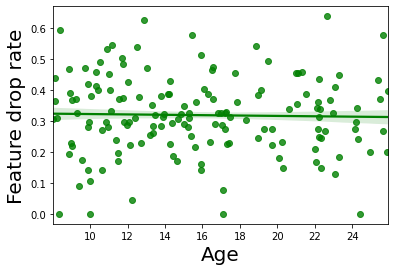

In [18]:
pars_mean = pars.groupby(['StudyID'], as_index=False).mean()
win_age = sb.regplot(x="ExactAge", y="feature drop rate", data=pars_mean, ci =68, color = "green")
plt.ylabel("Feature drop rate", fontsize=20)
plt.xlabel("Age", fontsize=20)


Text(0.5, 0, 'Age')

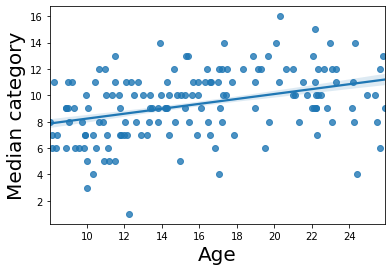

In [19]:
win_age = sb.regplot(x="ExactAge", y="category", data=df_age_medcat, ci =68)
plt.ylabel("Median category", fontsize=20)
plt.xlabel("Age", fontsize=20)


Text(0.5, 0, 'Age')

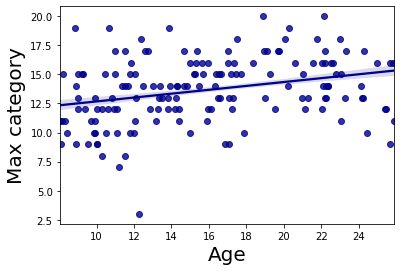

In [20]:
win_age = sb.regplot(x="ExactAge", y="category", data=df_age_maxcat, ci = 68, color = "Darkblue")
plt.ylabel("Max category", fontsize=20)
plt.xlabel("Age", fontsize=20)

Text(0.5, 0, 'Age')

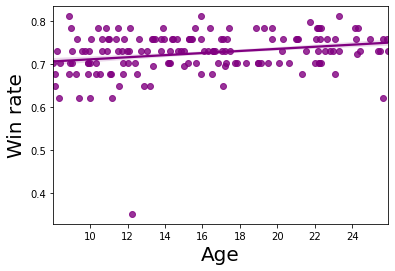

In [21]:
win_age = sb.regplot(x="ExactAge", y="win", data=df_age_winrate, ci=68, color = 'Purple')
plt.ylabel("Win rate", fontsize=20)
plt.xlabel("Age", fontsize=20)